<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-keras-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with TensorFlow 2 Keras Layers

## Objectives

- activation functions
- classification

Next step: analyse output with more metrics: https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-keras-classifier-metrics.ipynb

In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

## A new challange: predicting a category instead of a continous value

* so far we were inferring a continous value for another
* now we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binart classification

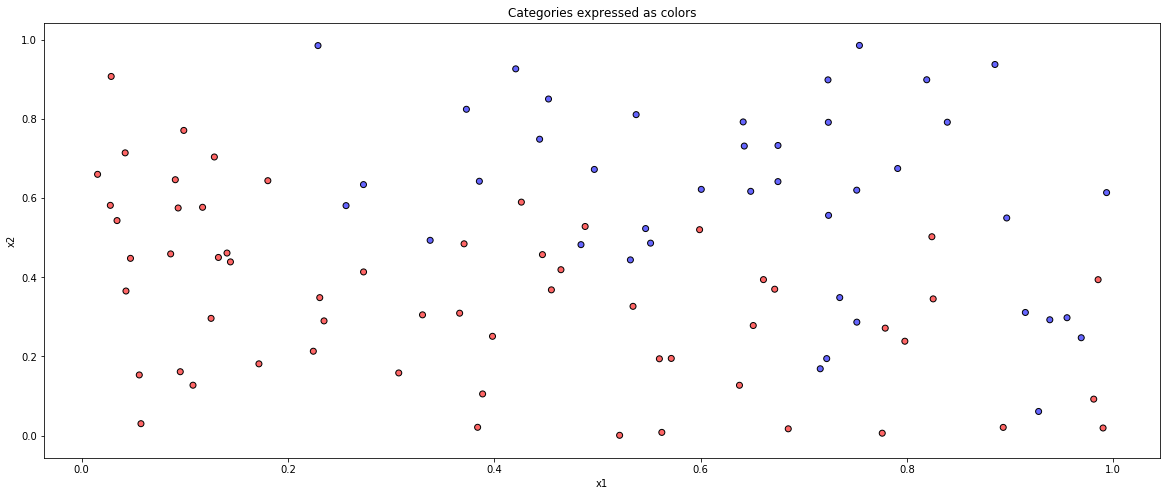

In [2]:
#@title Configure our example { display-mode: "form", run: "auto" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 100 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import numpy as np

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = noise_level * np.random.normal(0, 1, n)
y = X[:, 1] > m*X[:, 0]+b + noise
y = y.astype(int)

from matplotlib.colors import ListedColormap

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k');

### Shared Exercise: Can you think of an application for this? What could be on the axes?

_Let's adapt the example to something we can relate to_

## Training using so called 'Logictic Regression'

### We have two dimensions as input now

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc1'

In [4]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')
x.shape, y.shape

(TensorShape([100, 2]), (100,))

In [5]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [6]:
%%time 

model.compile(loss='mse', 
             optimizer='sgd')

history = model.fit(x, y_true, epochs=500, verbose=0)

CPU times: user 7.18 s, sys: 767 ms, total: 7.94 s
Wall time: 5.84 s


In [0]:
# save the model for later use and comparision with more metrics

model.save('linear-mse.h5')

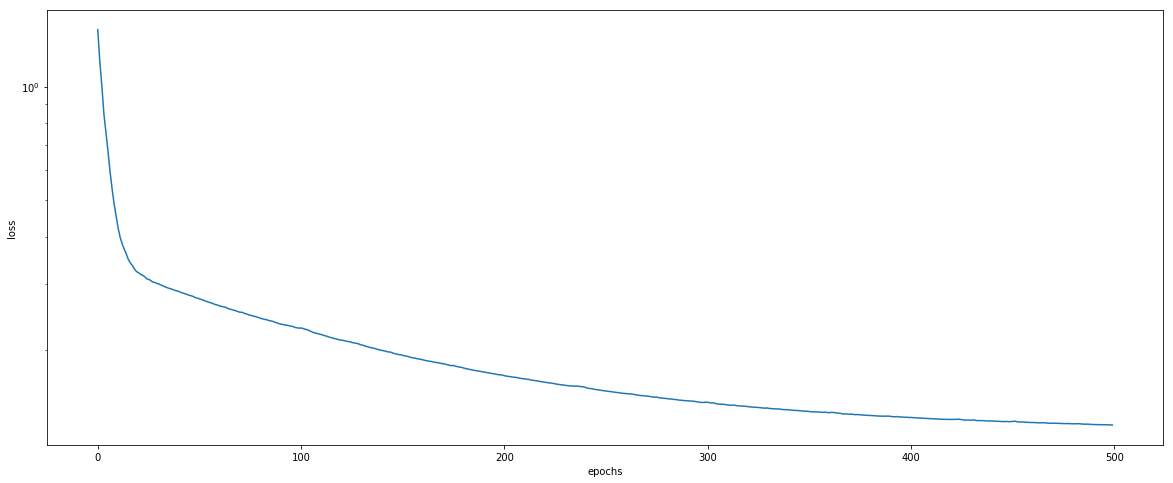

In [8]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);

### It does train ok, but how does the output look like?

Text(0.5, 1.0, 'Distribution of predictions')

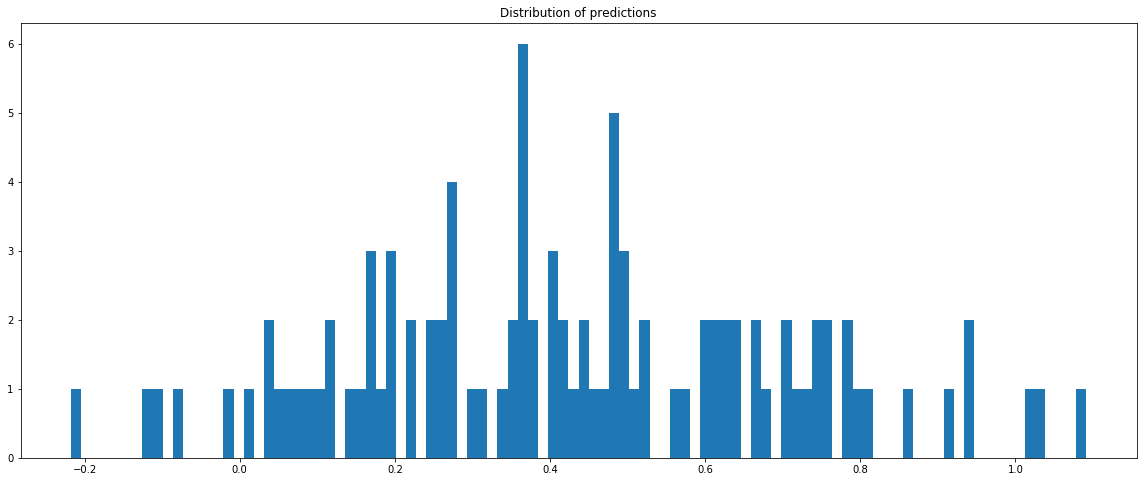

In [9]:
y_pred = model.predict(x)

plt.hist(y_pred, bins=n)
plt.title('Distribution of predictions')

Text(0.5, 1.0, 'Distribution of ground truth')

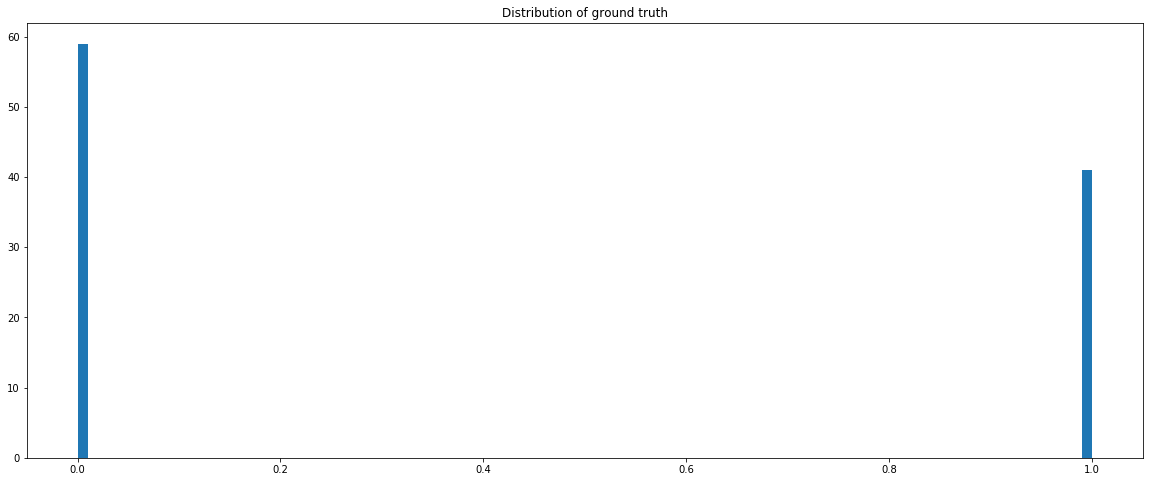

In [10]:
plt.hist(y, bins=n)
plt.title('Distribution of ground truth')

### How would we make a binary prediction out of this?

_typical approach: everything below 0.5 counts as 0, everthing above as 1_

### We would love to predict a value compressed between 0 and 1

_everything below 0.5 counts as 0, everthing above as 1_

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/logistic.jpg?raw=1'>

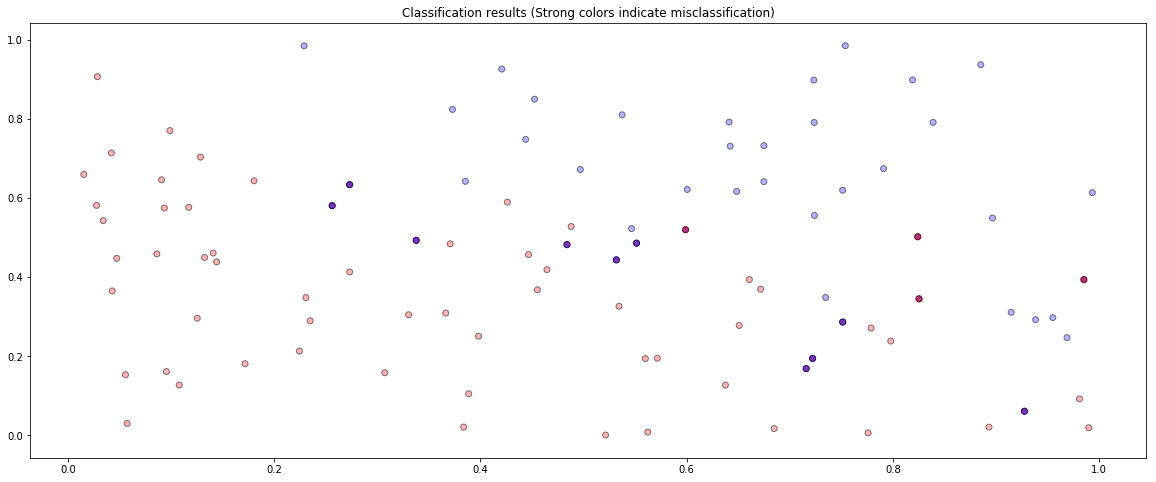

In [11]:
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)
misclassified = y_true - y_pred_binary
plt.scatter(X[:,0], X[:,1], c=misclassified, cmap=ListedColormap(['#FF0000', '#FFFFFF', '#0000FF']), marker='o')
plt.scatter(X[:,0], X[:,1], c=y_pred_binary, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k', alpha=0.5)
plt.title('Classification results (Strong colors indicate misclassification)');

### Interpretation

* some values are negative
* some are above 1
* we have a lot of variance

### Is there a way to decrease variance of the prediction and actually compress the values between 0 and 1?

## Understandinging the effect of activation functions


Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ai/img/activation-functions.jpg'>


### We can use sigmoid as the activation function

In [12]:
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Reconsidering the loss function

_cross entropy is an alternative to mean squared error_ 

* cross entropy can be used as an error measure when a network's outputs can be thought of as representing independent hypotheses
* activations can be understood as representing the probability that each hypothesis might be true
* the loss indicates the distance between what the network believes this distribution should be, and what the teacher says it should be 
* in this case we are dealing with two exclusive hypothesis: either a sample is blue or it is red
* this makes this binary cross entropy

https://en.wikipedia.org/wiki/Cross_entropy 

http://www.cse.unsw.edu.au/~billw/cs9444/crossentropy.html

### We also have a new metric: what share of predictions is correct?

* basic metric for classification: share of correctly predicted samples
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy


### Advanced Optimizer (pretty much standard)

In [13]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1000, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 18.1 s, sys: 1.78 s, total: 19.9 s
Wall time: 14.4 s


In [0]:
# save the model for later use and comparision with more metrics

model.save('sigmoid-crossentropy.h5')

In [15]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.34845574110746386, 0.86)

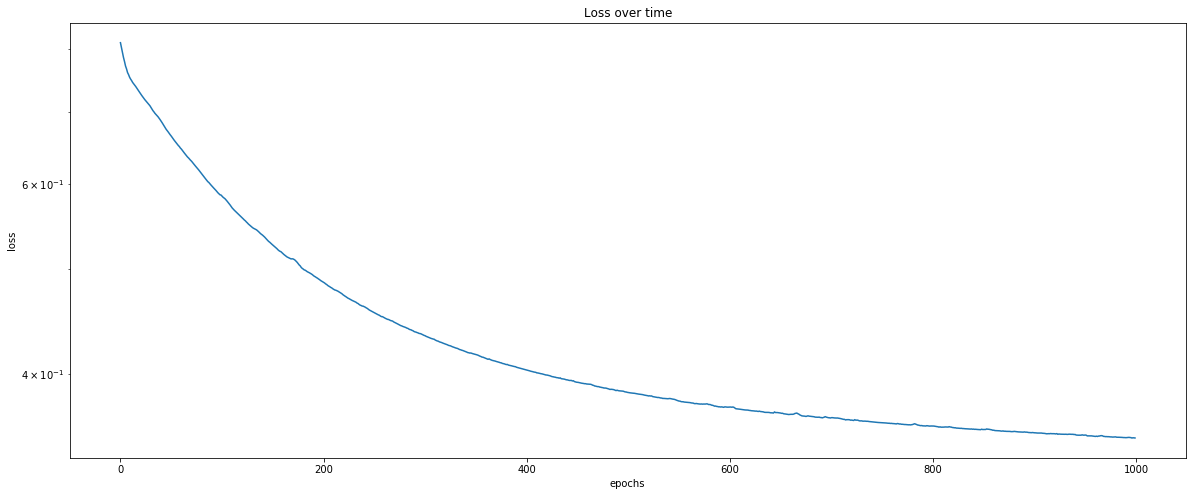

In [16]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

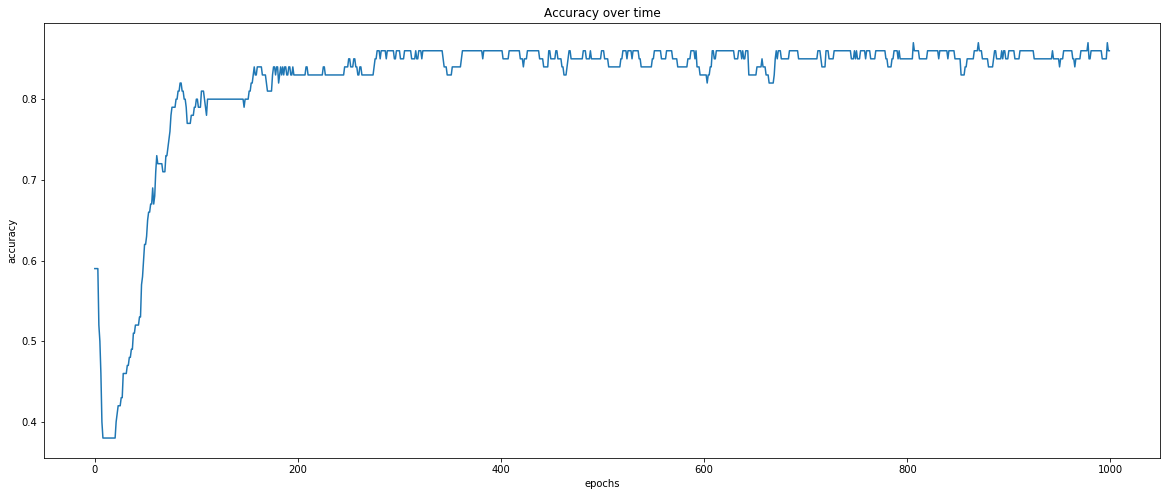

In [17]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

Text(0.5, 1.0, 'Distribution of predictions, more dense around extremes')

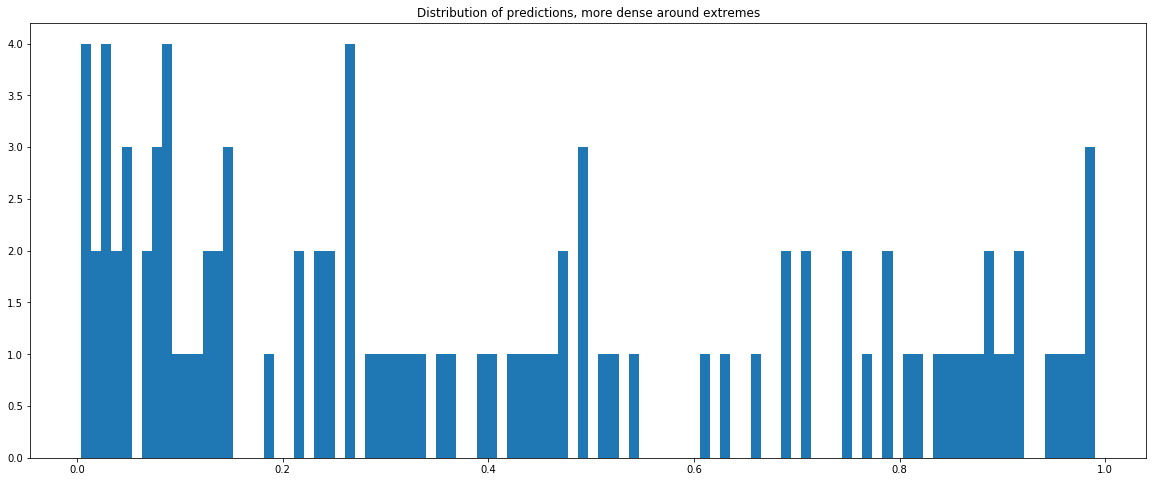

In [18]:
y_pred = model.predict(x)

plt.hist(y_pred, bins=n)
plt.title('Distribution of predictions, more dense around extremes')

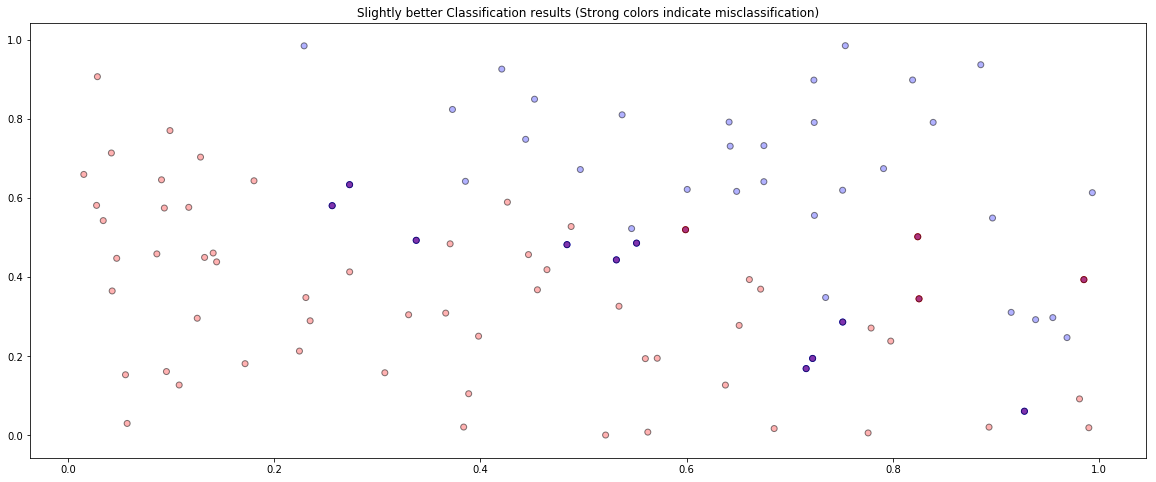

In [19]:
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)
misclassified = y_true - y_pred_binary
plt.scatter(X[:,0], X[:,1], c=misclassified, cmap=ListedColormap(['#FF0000', '#FFFFFF', '#0000FF']), marker='o')
plt.scatter(X[:,0], X[:,1], c=y_pred_binary, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k', alpha=0.5)
plt.title('Slightly better Classification results (Strong colors indicate misclassification)');

### Exercise: run this classification experiment with a bit more noise

* generated your own dataset using a bit more noise
* train the model and generate all the plots
* does all this make sense to you?

### Optional Advanced Exercise: What would you need to change to make this work with classes -1 and 1?

## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

### Advanced Exercise: Can a hidden layer improve the quality of prediction?

* use the playground to experiment with hidden layers
* under the hood the playground also uses a final neuron with tanh activation to decide between the two categories
* how would you add an additional hidden layer to the Keras style model definition?

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential
